# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットに対して特徴点を抽出するサンプルコードです。

In [1]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

Loading BokehJS ...

In [2]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [3]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9655193,1285672


In [4]:
# 対象データ設定
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [13]:
# 最初のショットを取得して確認
dr = DataReader()

shot_number = 2
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,displacement,load01,load02,load03,load04,shot_number,tags
0,1.606752e+09,3125,0,49.184,0.363158,0.526316,0.315789,0.673684,2,"[異常A, 異常B]"
1,1.606752e+09,3126,1,49.210,0.373684,0.515789,0.313158,0.676316,2,"[異常A, 異常B]"
2,1.606752e+09,3127,2,49.162,0.384211,0.526316,0.289474,0.692105,2,"[異常A, 異常B]"
3,1.606752e+09,3128,3,49.197,0.415789,0.565789,0.294737,0.660526,2,"[異常A, 異常B]"
4,1.606752e+09,3129,4,49.210,0.400000,0.521053,0.286842,0.631579,2,"[異常A, 異常B]"


In [14]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,80.598572,3125.0
1,2,80.613753,3113.0
2,3,80.594235,3129.0
3,4,80.636509,3097.0
4,5,80.582338,3140.0


In [15]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3098


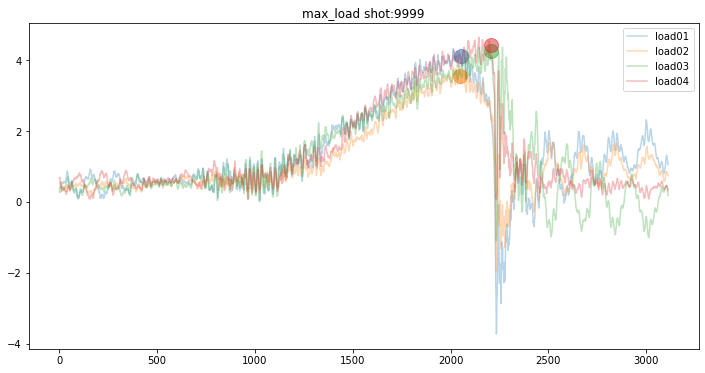

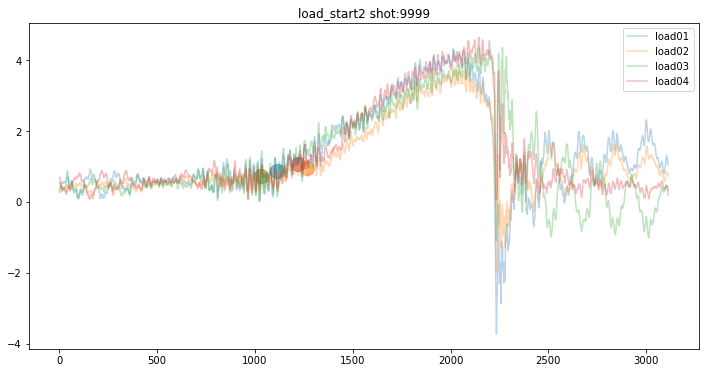

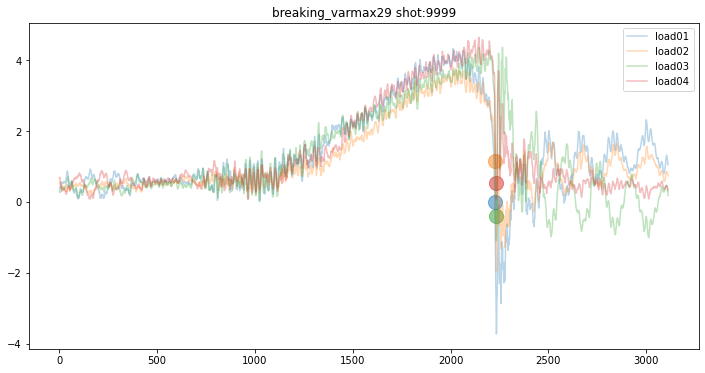

In [19]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_df, 80.0, max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, 80.0, load_start2, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, 80.0, breaking_varmax29, shot=shot_number, disp_chart=True)

In [20]:
# 各特徴点のインデックス番号と値を確認
print(f"最大荷重点：{max_load_indicies}, {max_load_values}")
print(f"荷重開始点：{load_start_indicies}, {load_start_values}")
print(f"破断点　　：{break_load_indicies}, {break_load_values}")

最大荷重点：[2053, 2050, 2205, 2204], [4.120568635830474, 3.5649440897862035, 4.264715492072577, 4.417202361696395]
荷重開始点：[1111, 1267, 1029, 1222], [0.8845337026777494, 0.9660137185067909, 0.7407400079145235, 1.0675966231367915]
破断点　　：[2226, 2226, 2233, 2233], [0.007894736842117833, 1.1499999999999906, -0.39999999999999836, 0.5421052631578975]


## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  
この処理には数分かかります。  

***max_func***：最大荷重点のロジック  
***start_func***: 荷重開始点のロジック  
***break_func***: 破断点ロジック  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [11]:
apply_all(
    target="20201201010000",
    max_func=max_load,
    start_func=load_start2,
    break_func=breaking_var_vrms,
    sub_func=narrowing_var_ch
)

2021-02-05 17:04:58,585 [INFO] apply start.
2021-02-05 17:05:33,219 [INFO] process 24507: data read finished. shot_number: 2877 - 3098. data count: 691667
Process Process-28:
Traceback (most recent call last):
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 230, in apply_all_analyze_logic
    max_points: List[dict] = apply_analyze_logic(
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 270, in apply_analyze_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 457, in extract_features
    sub_start 

TypeError: 'function' object is not subscriptable
2021-02-05 17:06:31,187 [INFO] process 24503: data read finished. shot_number: 1990 - 2210. data count: 688521
Process Process-24:
Traceback (most recent call last):
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 230, in apply_all_analyze_logic
    max_points: List[dict] = apply_analyze_logic(
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 270, in apply_analyze_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 457, in extract_features
    sub_

## データ読み込み
指定インデックスの全ショットデータをメモリ上に読み込みます。  
これには時間がかかりますが、ショットデータを繰り返し利用する際に便利です。  
時間目安：10,000,000件読み込みで約3分

In [22]:
# 全ショットデータ読み込み
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"

dr = DataReader()
shots_df = dr.read_all(shots_data_index)

2021-02-05 17:58:42,088 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-02-05 17:58:42,091 [INFO] データ件数: 9655193
2021-02-05 17:58:42,092 [INFO] Data read start. data_count: 9655193.
2021-02-05 18:01:21,365 [INFO] Data reading has finished.


In [23]:
shots_meta_index = "shots-" + target + "-meta"
shots_meta_df = dr.read_shots_meta(shots_meta_index)

In [34]:
for shot_number in range(1, len(shots_meta_df)+1):
    shot_df = shots_df[shots_df.shot_number == shot_number].reset_index()
    spm = shots_meta_df[shots_meta_df.shot_number == shot_number].spm
    
    max_load_indicies, max_load_values, max_debug_values = extract_features(shot_df, spm, max_load)
    break_load_indicies, break_load_values, break_debug_values = extract_features(shot_df, spm, breaking_varmax29, sub_func=None)    
    start_load_indicies, start_load_values, start_debug_values = extract_features(shot_df, spm, load_start2)

KeyboardInterrupt: 

In [ ]:
# 各特徴点のインデックス番号と値を確認
print(f"最大荷重点：{max_load_indicies}, {max_load_values}")
print(f"荷重開始点：{load_start_indicies}, {load_start_values}")
print(f"破断点　　：{break_load_indicies}, {break_load_values}")